# FIPS References

This notebook provides insights into the references of FIPS certificates.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import matplotlib
import matplotlib.pyplot as plt

from sec_certs.dataset.fips import FIPSDataset
from collections import Counter
from pprint import pprint

# Typing imports
from pandas.core.frame import DataFrame
from typing import Callable


#%matplotlib inline
#matplotlib.use("pgf")
sns.set_theme(style='white')
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams['lines.markersize'] = 4
plt.rcParams['savefig.pad_inches'] = 0.01
sns.set_palette("deep")

In [2]:
dset = FIPSDataset.from_web_latest()

In [3]:
df = dset.to_pandas()

## Analysis of FIPS references

In [4]:
refs_columns: list[str] = [
    "cert_id",
    "status",
    "standard",
    "type",
    "level",
    "embodiment",
    "module_directly_referenced_by", 
    "module_indirectly_referenced_by",
    "module_directly_referencing",
    "module_indirectly_referencing",
    "policy_directly_referenced_by",
    "policy_indirectly_referenced_by",
    "policy_directly_referencing",
    "policy_indirectly_referencing",
]

### References EDA

In [5]:
refs_df = df[refs_columns]

In [6]:
refs_direct_eda_df = refs_df[refs_df["module_directly_referencing"].notna()]
refs_indirect_eda_df = refs_df[refs_df["module_indirectly_referencing"].notna()]

In [7]:
def process_references(df: DataFrame, reference_type: str, func: Callable[[list[int]], float]) -> float | int:
    return func([len(refs) for refs in df[reference_type]])

#### Direct module references

In [8]:
direct_reference_type: str = "module_directly_referencing"
total_directly_referencing_certs: int = refs_direct_eda_df.shape[0]
total_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, sum)
maximum_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, max)
minimum_direct_references: int = process_references(refs_direct_eda_df, direct_reference_type, min)
mean_direct_references: float = round(process_references(refs_direct_eda_df, direct_reference_type, np.mean), 2)
median_direct_references: float = process_references(refs_direct_eda_df, direct_reference_type, np.median)

print(f"Total directly referencing certs: {total_directly_referencing_certs}")
print(f"Total direct references among all certs: {total_direct_references}")
print(f"Maximum directly referenced certs at once: {maximum_direct_references}")
print(f"Minimum directly referenced certs at once: {minimum_direct_references}")
print(f"Mean of all direct references: {mean_direct_references}")
print(f"Median of all direct references: {median_direct_references}")

Total directly referencing certs: 474
Total direct references among all certs: 627
Maximum directly referenced certs at once: 8
Minimum directly referenced certs at once: 1
Mean of all direct references: 1.32
Median of all direct references: 1.0


#### Indirect module references

In [9]:
indirect_reference_type: str = "module_indirectly_referencing"
total_indirectly_referencing_certs: int = refs_indirect_eda_df.shape[0]
total_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, sum)
maximum_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, max)
minimum_indirect_references: int = process_references(refs_indirect_eda_df, indirect_reference_type, min)
mean_indirect_references: float = round(process_references(refs_indirect_eda_df, indirect_reference_type, np.mean), 2)
median_indirect_references: float = process_references(refs_indirect_eda_df, indirect_reference_type, np.median)

print(f"Total indirectly referencing certs: {total_indirectly_referencing_certs}")
print(f"Total indirect references among all certs: {total_indirect_references}")
print(f"Maximum indirectly referenced certs at once: {maximum_indirect_references}")
print(f"Minimum indirectly referenced certs at once: {minimum_indirect_references}")
print(f"Mean of all indirect references: {mean_indirect_references}")
print(f"Median of all indirect references: {median_indirect_references}")

Total indirectly referencing certs: 474
Total indirect references among all certs: 1044
Maximum indirectly referenced certs at once: 27
Minimum indirectly referenced certs at once: 1
Mean of all indirect references: 2.2
Median of all indirect references: 1.0


#### Direct references per status

Text(0.5, 1.0, 'Fruit Distribution')

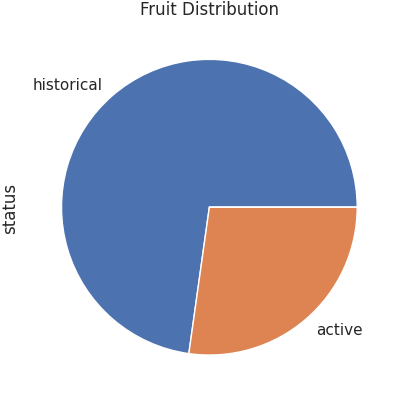

In [69]:
status_counts_df = refs_direct_eda_df["status"].value_counts()
status_counts_df.plot.pie()
plt.title('Fruit Distribution')


#### Direct references per type


#### Direct references per level

#### Direct references per embodiment

### Active certificates which reference at least one historical cert

In [10]:
def get_cert_property(df: DataFrame, cert_id: int, column: str) -> str | None:
    if column not in df.columns:
        raise ValueError(f"Dataset does not have column '{column}'")
    
    sub_df = df[df["cert_id"] == int(cert_id)]
    
    if not sub_df.shape[0]:  # Certificate is not in the dataset
        print(f"Cert ID: {cert_id} not in dataset")
        return None
    
    if sub_df.shape[0] > 1:  # There are more than one occurence with same ID
        print(f"Error Cert ID: {cert_id} has {sub_df.shape[0]} occurrences.")
        return None
    
    return sub_df.iloc[0][column]

def is_cert_referencing_historical_cert(dataset: DataFrame, cert_ids: set[int]) -> bool:
    return "historical" in [get_cert_property(dataset, cert_id, "status") for cert_id in cert_ids]

In [11]:
active_certs_referencing_historical: list[int] = []
active_referencing_certs: DataFrame = refs_df[(refs_df["status"] == "active") & (refs_df["module_directly_referencing"].notna())]

for _, rows in active_referencing_certs.iterrows():
    referencing_ids = rows["module_directly_referencing"]
        
    if is_cert_referencing_historical_cert(refs_df, referencing_ids):
        active_certs_referencing_historical.append(rows.cert_id)

hit_ratio: float = len(active_certs_referencing_historical) / len(active_referencing_certs)
print(f"Total active certificates referencing at least one historical: {len(active_certs_referencing_historical)}")
print(f"Total active certificates referencing at least one certificate: {len(active_referencing_certs)}")
print(f"Hit ratio: {round(hit_ratio, 2)}")

Total active certificates referencing at least one historical: 12
Total active certificates referencing at least one certificate: 129
Hit ratio: 0.09


### Certificates with higher levels referencing certficates with lower levels

In [12]:
referencing_certs: DataFrame = refs_df[refs_df["module_directly_referencing"].notna()]

In [13]:
def compare_levels(dataset: DataFrame, cert_ids: set[int], compare_to_level: int) -> int:
    is_referencing_any_lower_level = [get_cert_property(dataset, cert_id, "level") < compare_to_level for cert_id in cert_ids]
    return any(is_referencing_any_lower_level)

In [14]:
def get_certs_referencing_lower_level(refs_df: DataFrame, referencing_certs: DataFrame, compare_level: int) -> list[int]:
    cert_ids = []
    
    for _, rows in referencing_certs.iterrows():
        referencing_ids = rows["module_directly_referencing"]
        if compare_levels(refs_df, referencing_ids, compare_level):
            cert_ids.append(rows.cert_id)

    return cert_ids

#### Level 2 referencing at least one certificate of level 1

In [15]:
compare_level: int = 2
level2_ref_certs = referencing_certs[referencing_certs["level"] == compare_level]
certificates_referencing_lower_level: list[int] = get_certs_referencing_lower_level(refs_df, level2_ref_certs, compare_level)
ratio: float = len(certificates_referencing_lower_level) / level2_ref_certs.shape[0]
print(f"Total amount of certificates with level {compare_level} referencing at least one certificate: {level2_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(certificates_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 2 referencing at least one certificate: 40
Total amount of certicates with reference at least one certificate with lower level: 16
Hit ratio: 0.4


#### Level 3 referencing at least one certificate of level 1 or 2

In [16]:
compare_level: int = 3
level3_ref_certs = referencing_certs[referencing_certs["level"] == compare_level]
certificates_referencing_lower_level: list[int] = get_certs_referencing_lower_level(refs_df, level3_ref_certs, compare_level)
ratio: float = len(certificates_referencing_lower_level) / level3_ref_certs.shape[0]
print(f"Total amount of certificates with level {compare_level} referencing at least one certificate: {level3_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(certificates_referencing_lower_level)}")
print(f"Hit ratio: {round(ratio, 2)}")

Total amount of certificates with level 3 referencing at least one certificate: 27
Total amount of certicates with reference at least one certificate with lower level: 1
Hit ratio: 0.04


#### Level 4 referencing at least one certificate of level 1, 2 or 3

In [17]:
compare_level: int = 4
level4_ref_certs = referencing_certs[referencing_certs["level"] == compare_level]
total_level4_certs: int = df[df["level"] == 4].shape[0]
certificates_referencing_lower_level: list[int] = get_certs_referencing_lower_level(refs_df, level4_ref_certs, compare_level)

# TODO - implement the analysis and function needs to cope with empty df or something like that
print(f"Total amount of certificates with level {compare_level} referencing at least one certificate: {level4_ref_certs.shape[0]}")


Total amount of certificates with level 4 referencing at least one certificate: 0


### Distribution of references among embodiments

In [18]:
def get_embodiment_references(refs_df: DataFrame, embodiment: str) -> dict[str, int]:
    result: dict[str, int] = {}
    sub_df = refs_df[(refs_df["embodiment"] == embodiment) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_embodiment: str = get_cert_property(refs_df, cert_id, "embodiment")
            result[referenced_embodiment] = result.get(referenced_embodiment, 0) + 1
    
    return result

In [19]:
final_embodiment_statistics: dict[str, dict[str, int]] = {} 

for embodiment in refs_df["embodiment"].unique():
    final_embodiment_statistics[embodiment] = get_embodiment_references(refs_df, embodiment)

pprint(final_embodiment_statistics)

{'Multi-Chip Embedded': {'Multi-Chip Embedded': 13, 'Single Chip': 2},
 'Multi-Chip Stand Alone': {'Multi-Chip Embedded': 7,
                            'Multi-Chip Stand Alone': 546,
                            'Single Chip': 28},
 'Single Chip': {'Multi-Chip Embedded': 2,
                 'Multi-Chip Stand Alone': 1,
                 'Single Chip': 28}}


Text(0.5, 1.0, 'Direct references among FIPS embodiments')

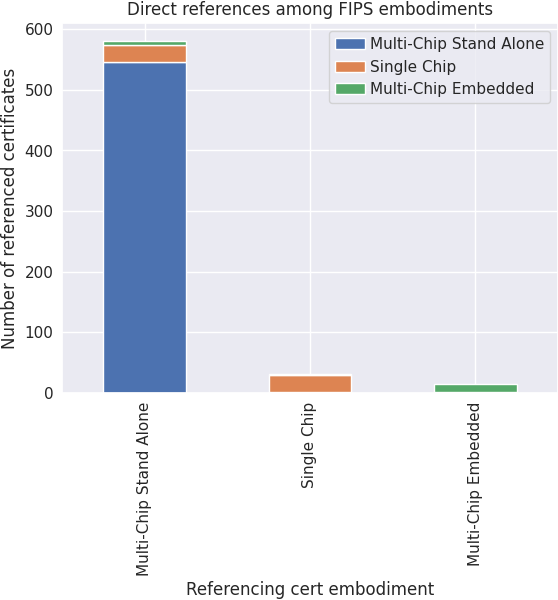

In [54]:
embodiment_df = pd.DataFrame(final_embodiment_statistics).fillna(0).astype(int).transpose()
embodiment_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert embodiment")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS embodiments")

### Distribution of references among types

In [52]:
def get_type_references(refs_df: DataFrame, cert_type: str) -> dict[str, int]:
    result = {}
    sub_df = refs_df[(refs_df["type"] == cert_type) & (refs_df["module_directly_referencing"].notna())]
    
    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_type: str = get_cert_property(refs_df, cert_id, "type")
            result[referenced_type] =result.get(referenced_type, 0) + 1

    return result

In [53]:
final_type_statistics: dict[str, dict[str, int]] = {}

for cert_type in refs_df["type"].unique():
    final_type_statistics[cert_type] = get_type_references(refs_df, cert_type)

pprint(final_type_statistics)

{'Firmware': {'Firmware': 1, 'Hardware': 1},
 'Firmware-Hybrid': {'Hardware': 2},
 'Hardware': {'Firmware': 2,
              'Firmware-Hybrid': 2,
              'Hardware': 76,
              'Software': 9},
 'Hybrid': {},
 'Software': {'Firmware': 1,
              'Hardware': 1,
              'Software': 502,
              'Software-Hybrid': 3},
 'Software hybrid': {},
 'Software-Hybrid': {'Hardware': 5, 'Software': 6, 'Software-Hybrid': 16}}


Text(0.5, 1.0, 'Direct references among FIPS certificate types')

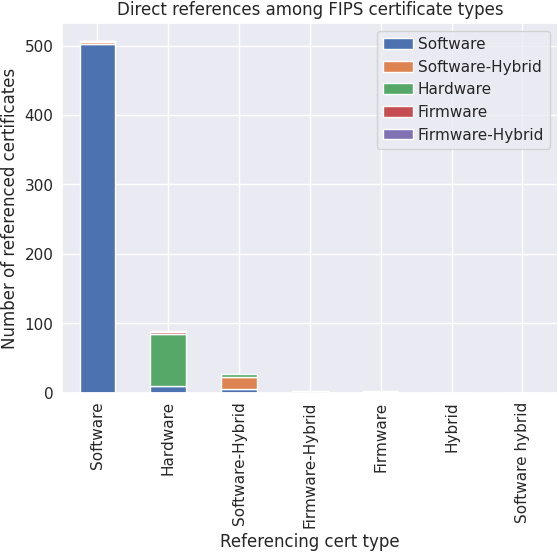

In [55]:
cert_type_df = pd.DataFrame(final_type_statistics).fillna(0).astype(int).transpose()
cert_type_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert type")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS certificate types")

### Cross-references among certificates

Certificate A directly references certificate B and at the same time certificate B directly references certificate A.
In other words intersection of `module_directly_referenced_by` and `module_directly_referencing` results into discovery of cross references in the dataset.

In [24]:
result: list[tuple[int, int]] = []
cross_references_df: DataFrame = df[(df["module_directly_referenced_by"].notna()) & (df["module_directly_referencing"].notna())]


for _, cert in cross_references_df.iterrows():
    referenced_by = cert["module_directly_referenced_by"]
    referencing = cert["module_directly_referencing"]
    cert_id = cert["cert_id"]
    
    intersection: set[str] = referenced_by & referencing
    
    
    for another_cert_id in intersection:
        another_cert_id_int = int(another_cert_id)
        
        if not (another_cert_id_int, cert_id) in result:
            result.append((cert_id, int(another_cert_id)))

print(result)
# TODO - Investigate how are 3382, 3383, 3384 related

[(3384, 3382), (3382, 3383), (80, 63)]
